<a href="https://colab.research.google.com/github/SumaSrija/ML-Project/blob/main/House_rent_prediction_ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy.stats import probplot, boxcox
from scipy.special import inv_boxcox
import pylab

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import Ridge, Lasso, BayesianRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
data=pd.read_csv("House_Rent_Dataset.csv")
data.head(10)

,Posted On,BHK,Rent,Size,Floor,Area Type,Area Locality,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact
0,2022-05-18,2,10000,1100,Ground out of 2,Super Area,Bandel,Kolkata,Unfurnished,Bachelors/Family,2,Contact Owner
1,2022-05-13,2,20000,800,1 out of 3,Super Area,"Phool Bagan, Kankurgachi",Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner
2,2022-05-16,2,17000,1000,1 out of 3,Super Area,Salt Lake City Sector 2,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner
3,2022-07-04,2,10000,800,1 out of 2,Super Area,Dumdum Park,Kolkata,Unfurnished,Bachelors/Family,1,Contact Owner
4,2022-05-09,2,7500,850,1 out of 2,Carpet Area,South Dum Dum,Kolkata,Unfurnished,Bachelors,1,Contact Owner
5,2022-04-29,2,7000,600,Ground out of 1,Super Area,Thakurpukur,Kolkata,Unfurnished,Bachelors/Family,2,Contact Owner
6,2022-06-21,2,10000,700,Ground out of 4,Super Area,Malancha,Kolkata,Unfurnished,Bachelors,2,Contact Agent
7,2022-06-21,1,5000,250,1 out of 2,Super Area,Malancha,Kolkata,Unfurnished,Bachelors,1,Contact Agent
8,2022-06-07,2,26000,800,1 out of 2,Carpet Area,"Palm Avenue Kolkata, Ballygunge",Kolkata,Unfurnished,Bachelors,2,Contact Agent
9,2022-06-20,2,10000,1000,1 out of 3,Carpet Area,Natunhat,Kolkata,Semi-Furnished,Bachelors/Family,2,Contact Owner


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4746 entries, 0 to 4745
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Posted On          4746 non-null   object
 1   BHK                4746 non-null   int64 
 2   Rent               4746 non-null   int64 
 3   Size               4746 non-null   int64 
 4   Floor              4746 non-null   object
 5   Area Type          4746 non-null   object
 6   Area Locality      4746 non-null   object
 7   City               4746 non-null   object
 8   Furnishing Status  4746 non-null   object
 9   Tenant Preferred   4746 non-null   object
 10  Bathroom           4746 non-null   int64 
 11  Point of Contact   4746 non-null   object
dtypes: int64(4), object(8)
memory usage: 445.1+ KB


In [ ]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
BHK,4746.0,2.083860,0.832256,1.0,2.0,2.0,3.0,6.0
Rent,4746.0,34993.451327,78106.412937,1200.0,10000.0,16000.0,33000.0,3500000.0
Size,4746.0,967.490729,634.202328,10.0,550.0,850.0,1200.0,8000.0
Bathroom,4746.0,1.965866,0.884532,1.0,1.0,2.0,2.0,10.0


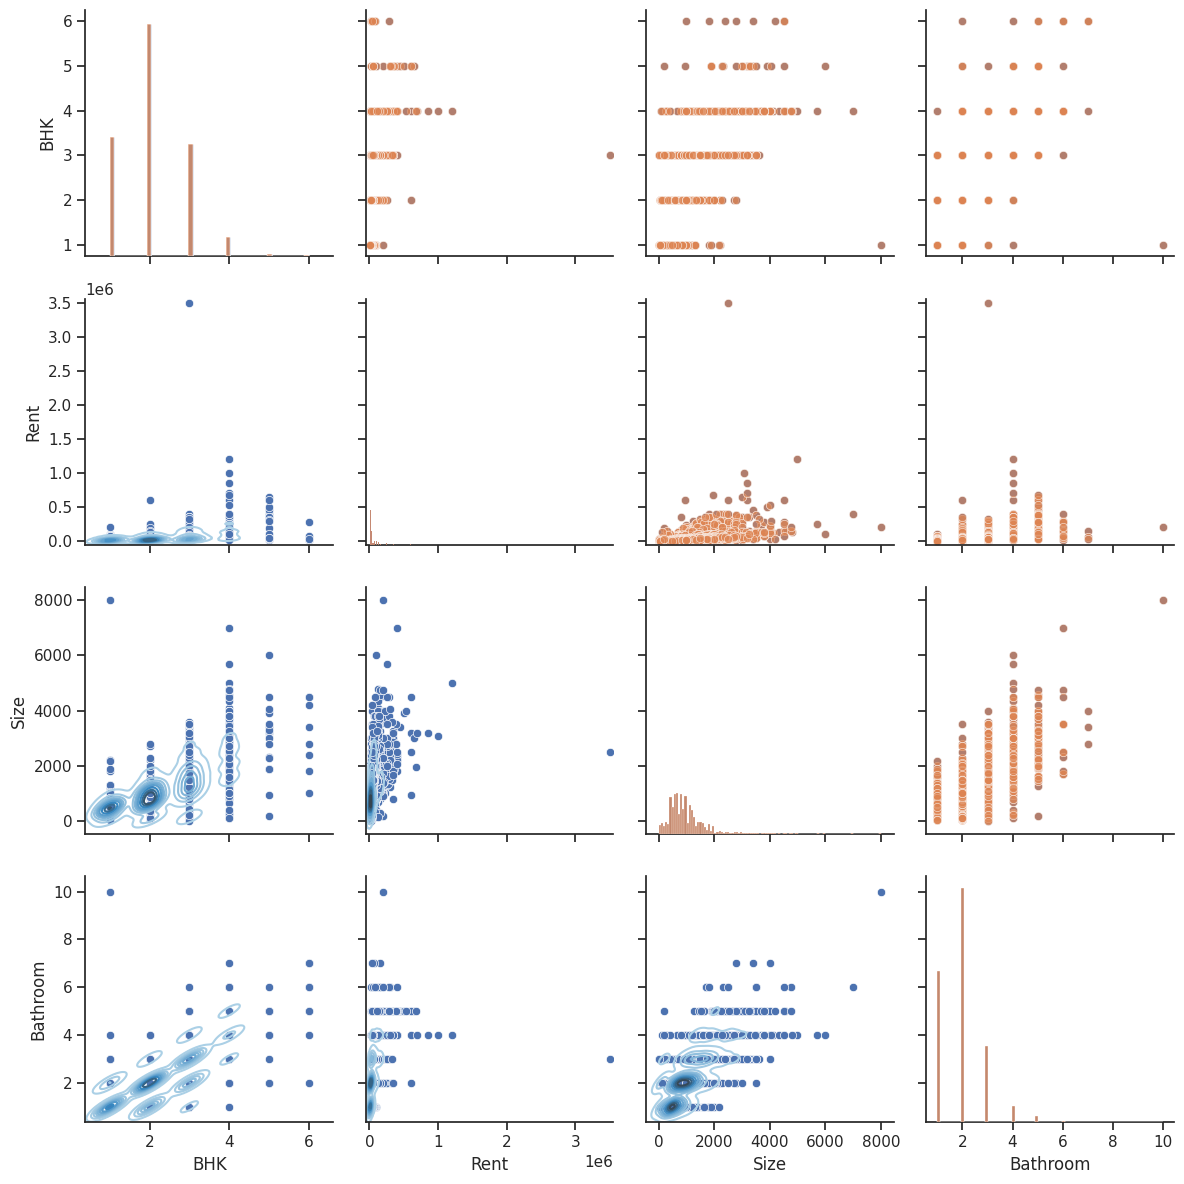

In [ ]:
sns.set(style="ticks")

# Create the pairplot
g = sns.pairplot(data, height=3)

g.map_upper(sns.scatterplot, alpha=0.7)
g.map_lower(sns.kdeplot, cmap="Blues_d")
g.map_diag(sns.histplot, kde_kws={"color": "R"})

plt.tight_layout()

plt.show()

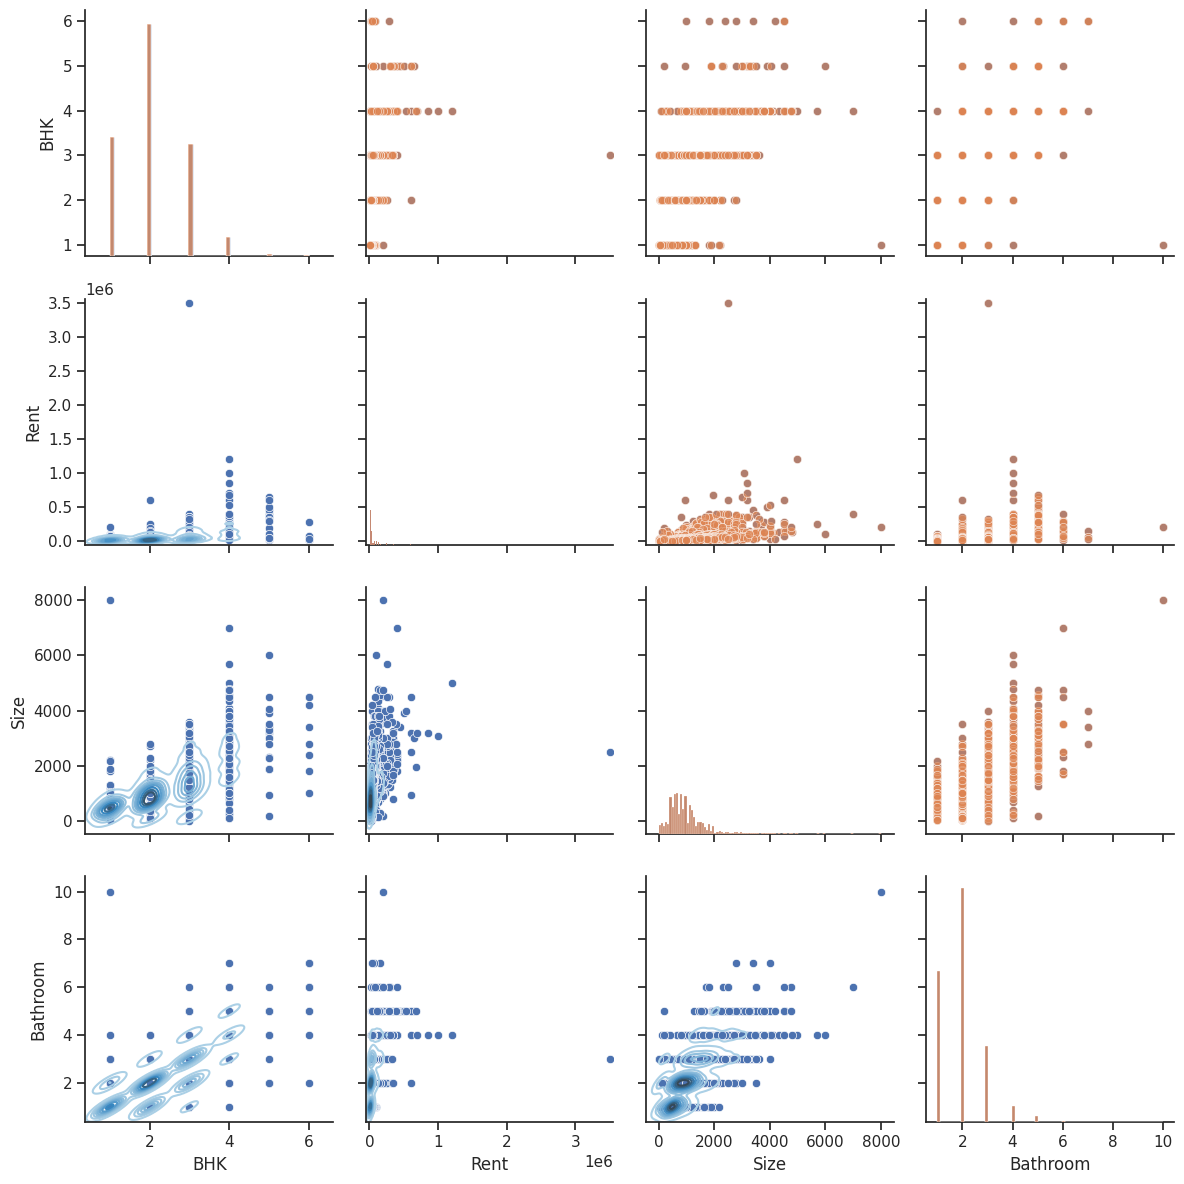

In [ ]:
sns.set(style="ticks")

# Create the pairplot
g = sns.pairplot(data, height=3)

g.map_upper(sns.scatterplot, alpha=0.7)
g.map_lower(sns.kdeplot, cmap="Blues_d")
g.map_diag(sns.histplot, kde_kws={"color": "R"})

plt.tight_layout()

plt.show()

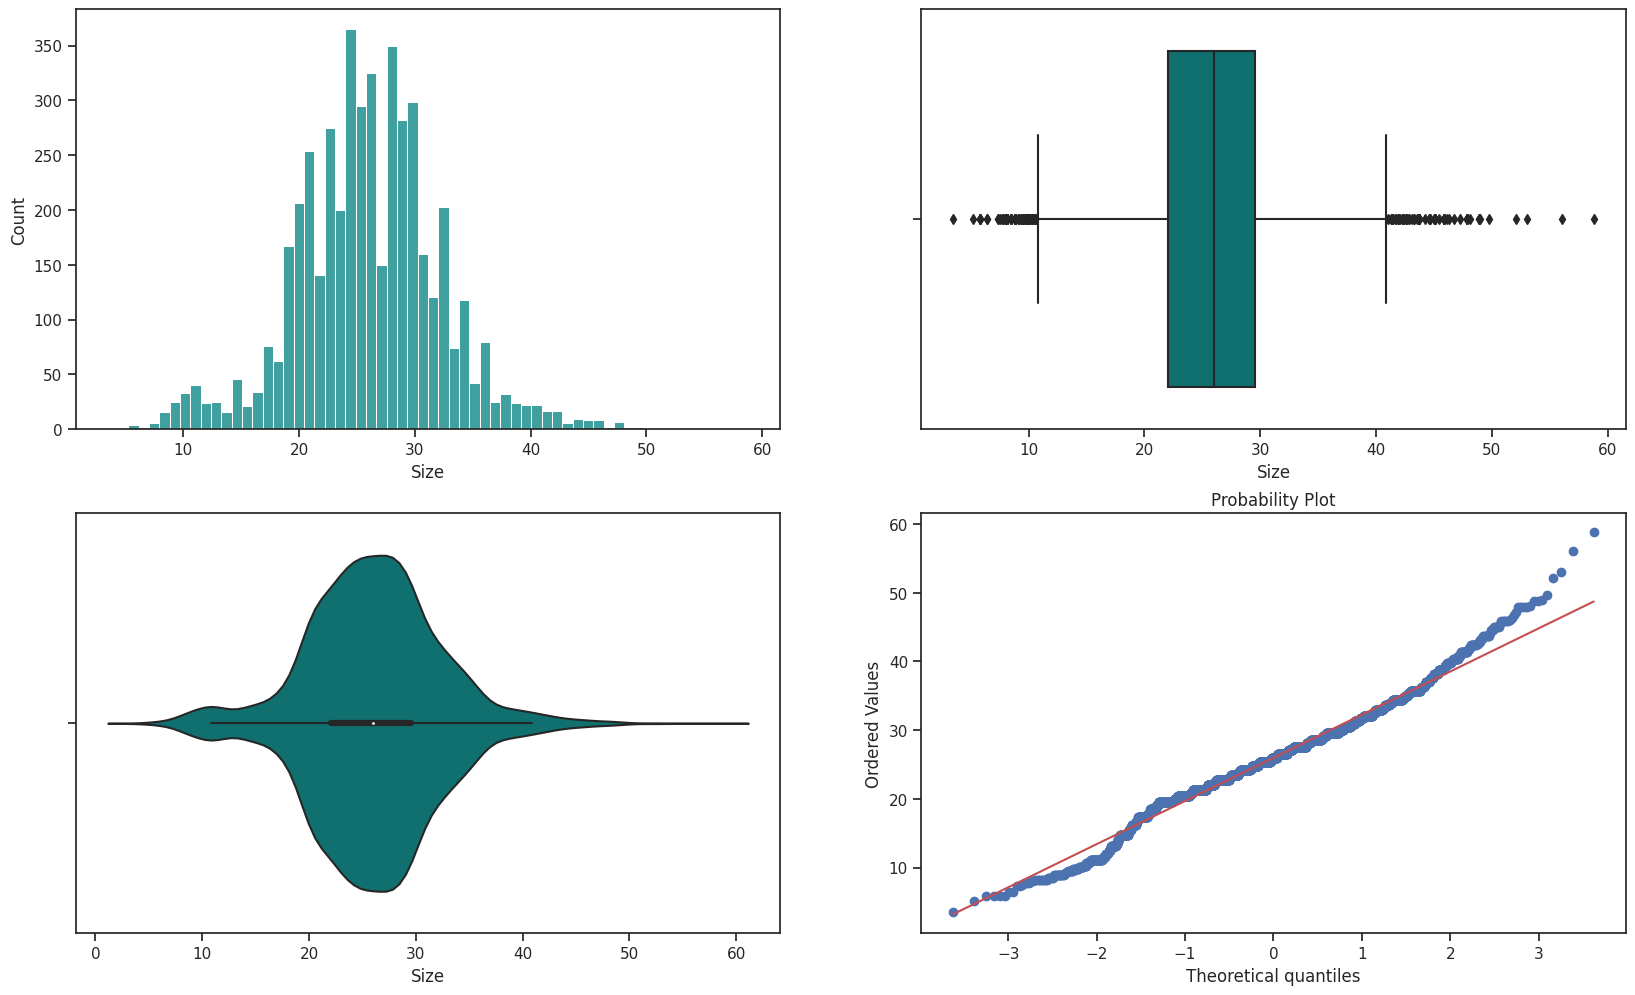

In [ ]:
data['Size'] = boxcox(data['Size'])[0]
fig, ax = plt.subplots(2, 2, figsize=(20, 12))
ax1 = sns.histplot(x = data['Size'], color='teal', ax= ax[0, 0])
ax2 = sns.boxplot(x = data['Size'], ax= ax[0, 1], color= 'teal')
ax3 = sns.violinplot(x = data['Size'], ax= ax[1, 0], color= 'teal')
ax4 = probplot(data['Size'], plot=pylab)
pylab.show()

Feature Extraction

In [ ]:
# Cleaing Floor Feature
data = data.join(data['Floor'].str.split(' out of ', 1, expand=True).rename(columns={0:'Floor Level', 1:'Total Floors'}))
data['Floor Level'] = data.apply(lambda x: 0 if x['Floor Level'] =='Ground' \
                                 else ( -1 if x['Floor Level'] =='Lower Basement' else (x['Total Floors']) ) , axis=1)

data.drop('Floor', axis=1, inplace=True)
data = data.dropna()
data['Floor Level'] = data['Floor Level'].astype(int)
data['Total Floors'] = data['Total Floors'].astype(int)

<ipython-input-11-0dadbc26d5f7>:2: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  data = data.join(data['Floor'].str.split(' out of ', 1, expand=True).rename(columns={0:'Floor Level', 1:'Total Floors'}))
<ipython-input-11-0dadbc26d5f7>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Floor Level'] = data['Floor Level'].astype(int)
<ipython-input-11-0dadbc26d5f7>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat

In [ ]:
print(data['Point of Contact'].value_counts())
print()
print(data['Area Type'].value_counts())

Contact Owner      3212
Contact Agent      1529
Contact Builder       1
Name: Point of Contact, dtype: int64

Super Area     2444
Carpet Area    2296
Built Area        2
Name: Area Type, dtype: int64


In [ ]:
import pandas as pd

# Assuming 'Posted On' is a column in your DataFrame
data['Posted On'] = pd.to_datetime(data['Posted On'])

data['month posted'] = data['Posted On'].dt.month
data['day posted'] = data['Posted On'].dt.day
data['day of week posted'] = data['Posted On'].dt.dayofweek  # Using 'dayofweek' instead of 'day_of_week'
data['quarter poster'] = data['Posted On'].dt.quarter

data.drop('Posted On', axis=1, inplace=True)
data.head()

,BHK,Rent,Size,Area Type,Area Locality,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact,Floor Level,Total Floors,month posted,day posted,day of week posted,quarter poster
0,2,10000,28.615008,Super Area,Bandel,Kolkata,Unfurnished,Bachelors/Family,2,Contact Owner,0,2,5,18,2,2
1,2,20000,25.391941,Super Area,"Phool Bagan, Kankurgachi",Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner,3,3,5,13,4,2
2,2,17000,27.613728,Super Area,Salt Lake City Sector 2,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner,3,3,5,16,0,2
3,2,10000,25.391941,Super Area,Dumdum Park,Kolkata,Unfurnished,Bachelors/Family,1,Contact Owner,2,2,7,4,0,3
4,2,7500,25.979077,Carpet Area,South Dum Dum,Kolkata,Unfurnished,Bachelors,1,Contact Owner,2,2,5,9,0,2


Encoding


In [ ]:
print(data.duplicated().sum())
data = data.drop_duplicates()

def one_hot_encode(data, column):
    encoded = pd.get_dummies(data[column], drop_first= True)
    data = data.drop(column, axis = 1)
    data = data.join(encoded)
    return data

data = data.drop('Area Locality', axis= 1)

columns = ['Area Type', 'City', 'Furnishing Status', 'Tenant Preferred', 'Point of Contact']
for col in columns:
    data = one_hot_encode(data, col)

data.head()

4


,BHK,Rent,Size,Bathroom,Floor Level,Total Floors,month posted,day posted,day of week posted,quarter poster,...,Delhi,Hyderabad,Kolkata,Mumbai,Semi-Furnished,Unfurnished,Bachelors/Family,Family,Contact Builder,Contact Owner
0,2,10000,28.615008,2,0,2,5,18,2,2,...,0,0,1,0,0,1,1,0,0,1
1,2,20000,25.391941,1,3,3,5,13,4,2,...,0,0,1,0,1,0,1,0,0,1
2,2,17000,27.613728,1,3,3,5,16,0,2,...,0,0,1,0,1,0,1,0,0,1
3,2,10000,25.391941,1,2,2,7,4,0,3,...,0,0,1,0,0,1,1,0,0,1
4,2,7500,25.979077,1,2,2,5,9,0,2,...,0,0,1,0,0,1,0,0,0,1


In [ ]:
from sklearn.preprocessing import StandardScaler

X = data.drop('Rent', axis= 1)
y = data['Rent']

bc_result = boxcox(y)
y_boxcox = bc_result[0]
lambda_ = bc_result[1]

X_train, X_test, y_train, y_test = train_test_split(X, y_boxcox, test_size= 0.2, random_state = 42)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
X_train.shape

(3790, 22)

Modelling


In [ ]:
import tensorflow as tf

model = tf.keras.Sequential()

model.add(tf.keras.layers.Dense(20))
model.add(tf.keras.layers.Dense(60))
model.add(tf.keras.layers.Dense(60))
model.add(tf.keras.layers.Dense(60))
model.add(tf.keras.layers.Dense(1))

model.compile(
    loss = 'mse',
    optimizer = tf.keras.optimizers.Adam(),
    metrics = [tf.keras.metrics.RootMeanSquaredError(name='rmse')]
)

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5)

Epoch 1/5
119/119 [==============================] - 5s 9ms/step - loss: 2.3408 - rmse: 1.5300 - val_loss: 0.0048 - val_rmse: 0.0693
Epoch 2/5
119/119 [==============================] - 1s 7ms/step - loss: 0.1506 - rmse: 0.3880 - val_loss: 0.0053 - val_rmse: 0.0727
Epoch 3/5
119/119 [==============================] - 1s 7ms/step - loss: 0.9544 - rmse: 0.9769 - val_loss: 0.0433 - val_rmse: 0.2081
Epoch 4/5
119/119 [==============================] - 0s 4ms/step - loss: 0.5419 - rmse: 0.7361 - val_loss: 0.0018 - val_rmse: 0.0421
Epoch 5/5
119/119 [==============================] - 0s 4ms/step - loss: 0.0207 - rmse: 0.1439 - val_loss: 0.0093 - val_rmse: 0.0966


In [ ]:
RMSE_ann = model.evaluate(X_test, y_test)[1]
RMSE_ann

30/30 [==============================] - 0s 4ms/step - loss: 0.0093 - rmse: 0.0966


0.0966261774301529

In [ ]:
models = {
    'ridge' : Ridge(),
    'xgboost' : XGBRegressor(),
    'catboost' : CatBoostRegressor(verbose=0),
    'lightgbm' : LGBMRegressor(),
    'gradient boosting' : GradientBoostingRegressor(),
    'lasso' : Lasso(),
    'random forest' : RandomForestRegressor(),
    'bayesian ridge' : BayesianRidge(),
    'support vector': SVR(),
    'knn' : KNeighborsRegressor(n_neighbors = 4)
}
for name, model in models.items():
    model.fit(X_train, y_train)
    print(f'{name} trained')

ridge trained
xgboost trained
catboost trained
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001061 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 455
[LightGBM] [Info] Number of data points in the train set: 3790, number of used features: 21
[LightGBM] [Info] Start training from score 2.811348
lightgbm trained
gradient boosting trained
lasso trained
random forest trained
bayesian ridge trained
support vector trained
knn trained


In [ ]:
results = {}
kf = KFold(n_splits= 10)

for name, model in models.items():
    result = np.mean(np.sqrt(-cross_val_score(model, X_train, y_train, scoring = 'neg_mean_squared_error', cv= kf)))
    results[name] = result

results['ANN'] = RMSE_ann
for name, result in results.items():
    print(f"{name} : {round(result, 3)}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000475 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 449
[LightGBM] [Info] Number of data points in the train set: 3411, number of used features: 21
[LightGBM] [Info] Start training from score 2.811457
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000500 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 450
[LightGBM] [Info] Number of data points in the train set: 3411, number of used features: 21
[LightGBM] [Info] Start training from score 2.811300
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000477 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, y

Evaluation

In [ ]:
results_df = pd.DataFrame(results, index=range(0,1)).T.rename(columns={0: 'RMSE'}).sort_values('RMSE', ascending=False)
results_df

,RMSE
ANN,0.096626
support vector,0.041339
lasso,0.029553
knn,0.015631
ridge,0.014212
bayesian ridge,0.014211
xgboost,0.013859
random forest,0.013813
lightgbm,0.013579
gradient boosting,0.013375


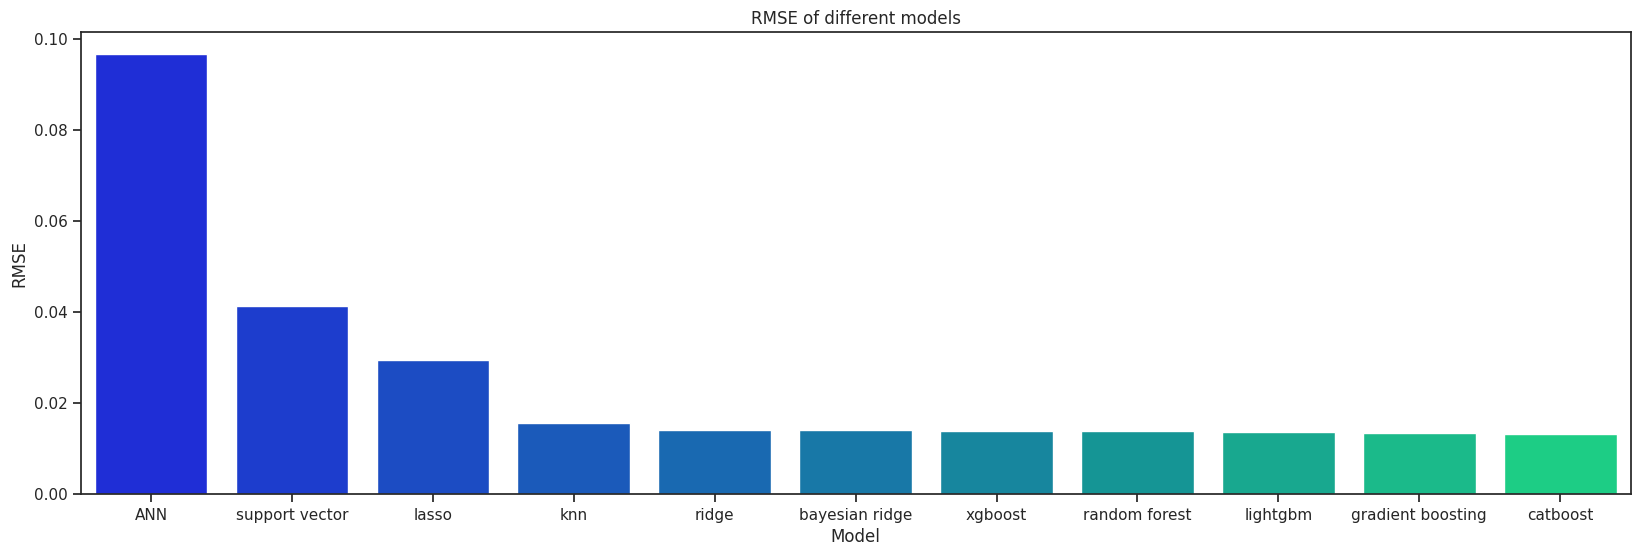

In [ ]:
plt.figure(figsize = (20, 6))
sns.barplot(x= results_df.index, y = results_df['RMSE'], palette = 'winter')
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.title('RMSE of different models');